In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and feature selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, VarianceThreshold

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Model Evaluation and Selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dimensionality Reduction
from sklearn.decomposition import PCA

In [2]:
# This is a feature selection and machine learning pipeline for GEMS and SNAPSHOT study 

# Update the dataset after applying combat, as it diminishes the influence from the scanner.
df1 = pd.read_csv('result.csv')
df2 = pd.read_csv('msresult.csv')
df3 = pd.read_csv('GEMS_SNAPSHOT_Aurora.csv')

#CLEANING DATA START(vary between studies)
common_columns = df1.columns.intersection(df2.columns)
df2 = df2[common_columns]
df = pd.concat([df1, df2], ignore_index=True)
df = df.dropna()
df.drop(df.iloc[:, 1:16], axis=1, inplace=True)
columns_to_drop = ['diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash','diagnostics_Mask-original_Size','diagnostics_Mask-original_Spacing','diagnostics_Mask-original_BoundingBox','diagnostics_Mask-original_CenterOfMassIndex','diagnostics_Mask-original_CenterOfMass']
df.drop(columns_to_drop, axis=1, inplace=True)

# Categorize data into 4 groups of interest: healthy, low risk, and high risk"
# Define the ID groups for each risk level
# low risk group
group_1_ids = set([
    'P56', 'P57', 'P58', 'P60', 'P61', 'P66', 'P68', 'P71', 'P73', 'P74',
    'P75', 'P78', 'P79', 'P81', 'P82', 'P84', 'P86', 'P87', 'P88', 'P89',
    'P90', 'P91', 'P94', 'P100', 'P101', 'P103', 'P105', 'P106', 'P107',
    'P108', 'P109', 'P113', 'P114', 'P117', 'P118', 'P122', 'P124', 'P125',
    'P128', 'P129', 'P134', 'P135', 'P136', 'P137', 'P138', 'P141', 'P142',
    'P143', 'P144', 'P145', 'P146', 'P148', 'P149', 'P150', 'P151', 'P153',
    'P154', 'P155'
])
#high risk group
group_2_ids = set([
    'P59', 'P62', 'P63', 'P64', 'P65', 'P67', 'P69', 'P70', 'P72', 'P76',
    'P77', 'P80', 'P83', 'P85', 'P92', 'P93', 'P95', 'P96', 'P97', 'P98',
    'P99', 'P102', 'P104', 'P110', 'P111', 'P112', 'P115', 'P116', 'P119',
    'P120', 'P121', 'P123', 'P126', 'P127', 'P130', 'P131', 'P132', 'P133',
    'P139', 'P140', 'P147'
])
# Function to determine the group based on the ID
def determine_group(id_value):
    # Convert id_value to string to use string methods
    id_str = str(id_value)
    if id_str.startswith('P'):
        # Extract the numeric part of the ID and convert it to an integer
        id_number = int(id_str[1:])  # Assumes the ID format is 'P' followed by numbers
        if id_number >= 1 and id_number <= 55:
            return 0
        elif id_str in group_1_ids:
            return 1
        elif id_str in group_2_ids:
            return 2
    return 3
# Apply the function to the 'ID' column and insert the result into a new column at the second position
df.insert(1, 'Group (based on risk level)', df['ID'].apply(determine_group))

# add SDMT score to the dataset
# Convert 'Subject' in df3 and 'ID' in df to string
df3['Subject'] = df3['Subject'].astype(str)
df['ID'] = df['ID'].astype(str)

# Merging df with df3
df = pd.merge(df, df3[['Subject', 'SDMT']], left_on='ID', right_on='Subject', how='left')

# Drop the 'Subject' column from the merged DataFrame as it's redundant
df = df.drop(columns=['Subject'])

# Reorder columns to make 'SDMT' the second column
cols = df.columns.tolist() # Get a list of all columns
cols.insert(1, cols.pop(cols.index('SDMT'))) # Move 'SDMT' to the second position
df = df[cols]
df = df.dropna()

# Separate the target column from the features
y = df['SDMT']
y = y.astype(int)
# Drop the 'ID' and 'Group (based on risk level)' columns from the DataFrame
X = df.drop(['ID', 'Group (based on risk level)','SDMT'], axis=1)
#CLEANING DATA ENDS

In [3]:
# After cleaning the data we have:
# df is our dataframe
# y is SDMT score (target)
# X are all our featuers

# After cleaning the data, we ended up with a total of 1,565 features. 
# This number presents a significant challenge for many feature selection algorithms. 
# Therefore, selecting a reasonable subset of features before implementing complex feature selection methods would be more effective. 
# A practical approach for initial rough selection is to assess how well each variable correlates with our target, the SDMT score.


In [4]:
# 1.Rough feature selection based on correlation
# Calculate correlation
correlation_with_target = X.corrwith(y)
# Sort by absolute value in descending order and select top 100
correlation_with_target= correlation_with_target.abs().sort_values(ascending=False).head(100).index
X = X[correlation_with_target]

In [ ]:
# with p value <0.05 and r value

In [5]:
# y is SDMT score (target)
# X is the top 100 features based on the correlation with y

In [6]:
# After researching on several feature selection algorithms, Lasso regression seemls like the most reasonable method to use. Breif reasoning(See below)

# 2.Feature selection using Lasso regression
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Lasso Regression
# LassoCV automatically finds the best alpha using cross-validation
alphas = np.logspace(-4, -0.5, 30)
lasso = LassoCV(cv=5, max_iter = 200000, tol = 0.01)
lasso.fit(X_scaled, y)

# Identify the features that Lasso kept (non-zero coefficients)
selected_features = np.where(lasso.coef_ != 0)[0]
X_selected = X.iloc[:, selected_features]

In [7]:
# y is SDMT score (target)
# X is now has 33 features

In [8]:
column_names = X_selected.columns
# Print each column name
for col in column_names:
    print(col)

square_glszm_ZoneVariance
wavelet-LHL_glszm_ZoneVariance
wavelet-LHH_glszm_ZoneVariance
square_glszm_LargeAreaEmphasis
wavelet-HHL_glszm_ZoneVariance
gradient_gldm_DependenceNonUniformity
wavelet-HLH_glszm_ZoneVariance
gradient_glrlm_LongRunLowGrayLevelEmphasis
wavelet-HHH_glszm_ZoneVariance
wavelet-HLL_glszm_ZoneVariance
gradient_firstorder_RobustMeanAbsoluteDeviation
lbp-3D-k_glrlm_LongRunLowGrayLevelEmphasis
lbp-3D-k_glszm_ZoneVariance
lbp-3D-k_glrlm_LongRunEmphasis
wavelet-LHL_gldm_GrayLevelNonUniformity
gradient_firstorder_InterquartileRange
original_shape_MeshVolume
wavelet-LLH_gldm_GrayLevelNonUniformity
lbp-3D-k_glszm_LargeAreaEmphasis
wavelet-HLL_gldm_GrayLevelNonUniformity
wavelet-LLH_glszm_ZoneVariance
squareroot_glrlm_GrayLevelNonUniformity
squareroot_glcm_Imc1
diagnostics_Image-original_Mean
exponential_glrlm_LongRunLowGrayLevelEmphasis
exponential_glrlm_LongRunEmphasis
exponential_glrlm_LongRunHighGrayLevelEmphasis
lbp-2D_glrlm_LongRunEmphasis
lbp-3D-m1_glrlm_LongRunHighG

In [9]:
# Machine learning 

class Regressors():
    def __init__(self, X,y):
        ''' 
        Convert the given pandas dataframe into training and testing data.
        '''
        X = X.to_numpy()  
        y = y.to_numpy()               
        self.training_data, self.testing_data, self.training_labels, self.testing_labels = train_test_split(X, y, test_size=0.4, random_state=42)
        self.outputs = []
        
    def test_regressor(self, reg, regressor_name=''):
        # Fit the regressor and extract metrics
        reg.fit(self.training_data, self.training_labels)

        # Extract the best parameters if GridSearchCV is used
        best_params = reg.best_params_ if isinstance(reg, GridSearchCV) else 'N/A'

        # Predictions for training and testing sets
        y_pred_train = reg.predict(self.training_data)
        y_pred_test = reg.predict(self.testing_data)

        # Calculate metrics for training data
        mae_train = mean_absolute_error(self.training_labels, y_pred_train)
        mse_train = mean_squared_error(self.training_labels, y_pred_train)
        rmse_train = np.sqrt(mse_train)
        r2_train = r2_score(self.training_labels, y_pred_train)

        # Calculate metrics for testing data
        mae_test = mean_absolute_error(self.testing_labels, y_pred_test)
        mse_test = mean_squared_error(self.testing_labels, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(self.testing_labels, y_pred_test)

        # Store the results, including best parameters
        self.outputs.append(f"{regressor_name} - Best Params: {best_params} - Training: MAE: {mae_train}, MSE: {mse_train}, RMSE: {rmse_train}, R2: {r2_train}; Testing: MAE: {mae_test}, MSE: {mse_test}, RMSE: {rmse_test}, R2: {r2_test}")

    def regressWithKNeighbors(self):
        # Code to run a K Nearest Neighbors regressor
        reg = GridSearchCV(KNeighborsRegressor(), {'n_neighbors': list(range(1, 20, 2)), 'leaf_size': list(range(5, 31, 5))}, cv=5)
        self.test_regressor(reg, 'K Nearest Neighbors')
    
    def regressWithLinear(self):
        # Linear Regression does not have hyperparameters for GridSearch in its basic form
        reg = LinearRegression()
        self.test_regressor(reg, 'Linear Regression')

    def regressWithDecisionTree(self):
        # Decision Tree Regressor with GridSearch
        reg = GridSearchCV(DecisionTreeRegressor(), 
                           {'max_depth': list(range(1, 51)), 'min_samples_split': list(range(2, 11))}, 
                           cv=5)
        self.test_regressor(reg, 'Decision Tree')

    def regressWithRandomForest(self):
        # Random Forest Regressor with GridSearch
        reg = GridSearchCV(RandomForestRegressor(), 
                           {'max_depth': list(range(1, 11)), 'min_samples_split': list(range(2, 11))}, 
                           cv=5)
        self.test_regressor(reg, 'Random Forest')

    def regressWithAdaBoost(self):
        # AdaBoost Regressor with GridSearch
        reg = GridSearchCV(AdaBoostRegressor(), 
                           {'n_estimators': list(range(10, 101, 10)), 'learning_rate': [0.01, 0.1, 1]}, 
                           cv=5)
        self.test_regressor(reg, 'AdaBoost')

In [10]:
# Main execution
if __name__ == "__main__":
    models = Regressors(X_selected,y)
    
    # Running all the regression methods
    print('Regressing with Linear Regression...')
    models.regressWithLinear()
    print('Regressing with K Neighbors...')
    models.regressWithKNeighbors()
    print('Regressing with Decision Tree...')
    models.regressWithDecisionTree()
    print('Regressing with Random Forest...')
    models.regressWithRandomForest()
    print('Regressing with AdaBoost...')
    models.regressWithAdaBoost()

    # Output the results to a file
    with open("output.csv", "w") as f:
        print('Model, Best Parameters, Training MAE, Training MSE, Training RMSE, Training R2, Testing MAE, Testing MSE, Testing RMSE, Testing R2', file=f)
        for line in models.outputs:
            print(line, file=f)

Regressing with Linear Regression...
Regressing with K Neighbors...
Regressing with Decision Tree...
Regressing with Random Forest...
Regressing with AdaBoost...


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 11.153254108335373
Mean Squared Error (MSE): 206.41338473546867
Root Mean Squared Error (RMSE): 14.3670938166168
R-squared: 0.09820601156036557


In [12]:
# Simple linear regression
# Initialize SVR
svr_model = SVR(kernel='rbf')

# Train the model
svr_model.fit(X_train, y_train)

# Predict
y_pred= svr_model.predict(X_test)

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 11.2714376029871
Mean Squared Error (MSE): 209.56247007186428
Root Mean Squared Error (RMSE): 14.476272658107275
R-squared: 0.08444805575200376


In [13]:
# Random Forest
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")


Mean Absolute Error (MAE): 4.908967032967033
Mean Squared Error (MSE): 47.55365714285715
Root Mean Squared Error (RMSE): 6.895915975623336
R-squared: 0.7922440824527635


In [14]:
#K nearest neighbors
# Initialize and train KNN
knn_model = KNeighborsRegressor(n_neighbors=20)  # Number of neighbors can be tuned
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn_model.predict(X_test)

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 11.302087912087913
Mean Squared Error (MSE): 210.99445604395606
Root Mean Squared Error (RMSE): 14.525648214243523
R-squared: 0.07819189003476013


In [15]:
from sklearn.neural_network import MLPRegressor

# Initialize and train MLP Regressor
nn_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)
nn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = nn_model.predict(X_test)

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 5021.660276891658
Mean Squared Error (MSE): 220457981.23303893
Root Mean Squared Error (RMSE): 14847.827492028553
R-squared: -963152.05538096


In [48]:
#Feature selection base using RFE
#
# Split the data into training and testing sets for a more robust feature evaluation
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the linear regression model
#model = LinearRegression()

# Initialize RFE with the linear regression model, selecting a number of features, e.g., 10
#rfe = RFE(model, n_features_to_select=10)

# Fit RFE
#rfe.fit(X_train, y_train)

# Print the ranking of the features
#feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
#print("Feature Ranking:\n", feature_ranking)

In [49]:
#Feature selection base on basic correlation
# Concatenate features and target into a single DataFrame for analysis
data = pd.concat([X, y.rename('y')], axis=1)
# Compute the correlation with the target variable
correlation = data.corrwith(data['y']).sort_values(ascending=False)
# Drop the target variable itself from the correlation series
correlation = correlation.drop('y', axis=0)
# Sort the correlation values by their absolute value and select the top 20
filtered_correlation = correlation.abs().sort_values(ascending=False).head(30)

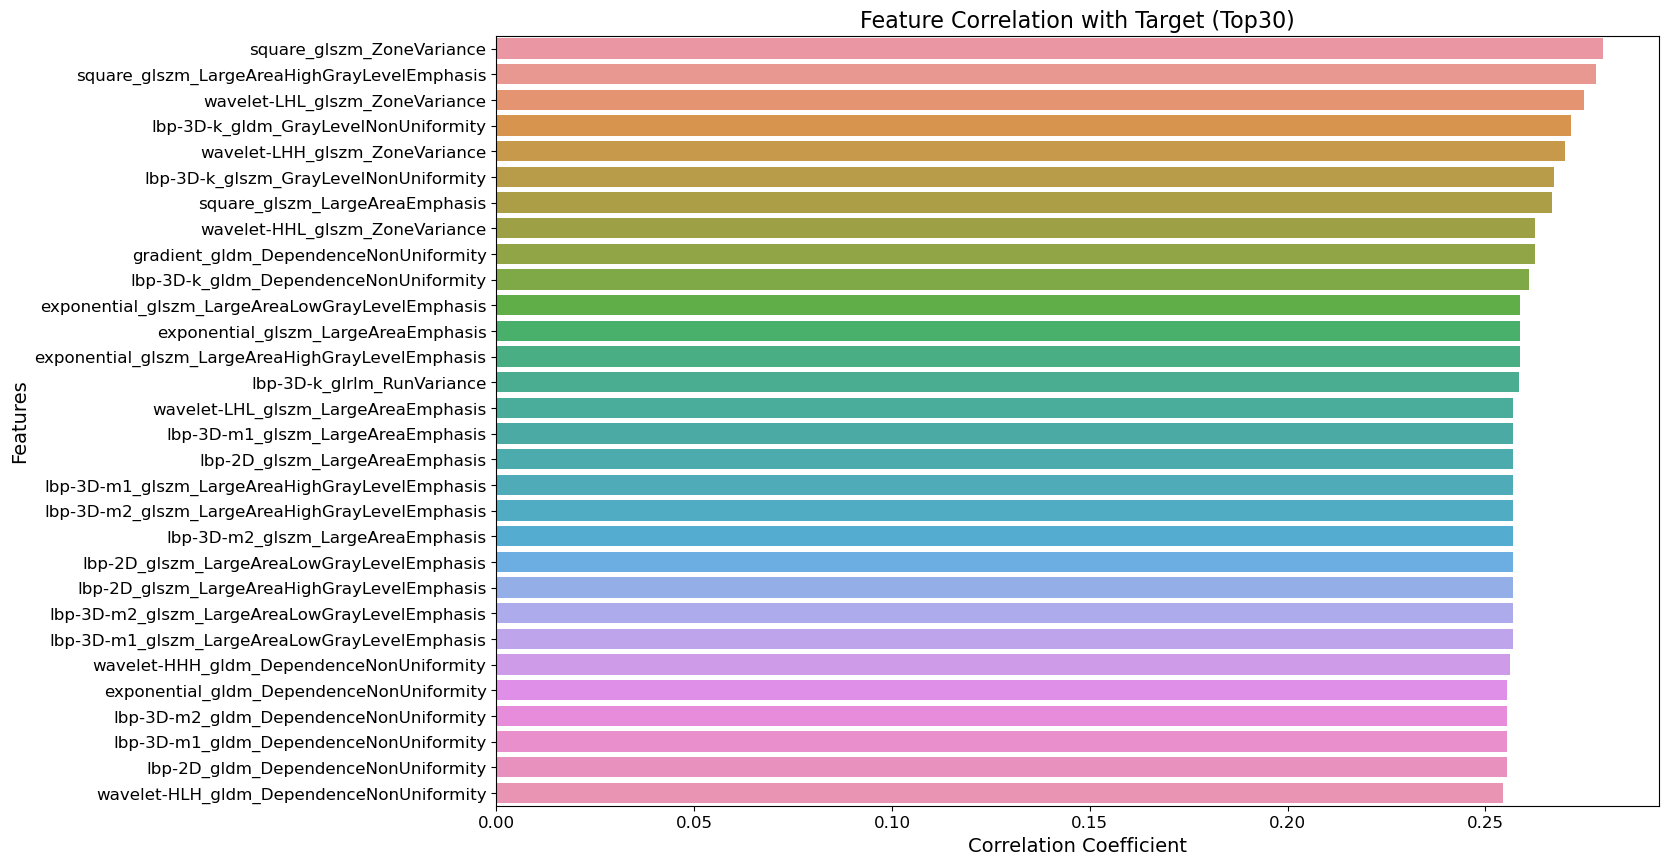

In [34]:
# Plotting the filtered correlations
plt.figure(figsize=(15, 10))
sns.barplot(x=filtered_correlation.values, y=filtered_correlation.index)
plt.title('Feature Correlation with Target (Top30)', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [40]:
# Separate the target column from the features
y = df['Group (based on risk level)']

# Drop the 'ID' and 'Group (based on risk level)' columns from the DataFrame
X = df.drop(['ID', 'Group (based on risk level)'], axis=1)

# Scale the features to be non-negative
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled array back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Apply VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_scaled_df)
X_filtered = X_scaled_df.loc[:, constant_filter.get_support()]

# SelectKBest is a feature selection method.
# For classification tasks, common scoring functions are 
#  1.chi2
#  2.f_classif (ANOVA F-value)
#  3.mutual_info_classif.

# 1.Apply SelectKBest with chi2
best_features_chi2 = SelectKBest(score_func=chi2, k=10)
fit_chi2 = best_features_chi2.fit(X_filtered, y)
selected_features_chi2 = X_filtered.columns[fit_chi2.get_support()]
X_selected_chi2 = X_filtered.loc[:, selected_features_chi2]

In [44]:
# Apply SelectKBest with f_classif
best_features_f_classif = SelectKBest(score_func=f_classif, k=20)
fit_f_classif = best_features_f_classif.fit(X_filtered, y)
scores_f_classif = fit_f_classif.scores_

# Apply SelectKBest with mutual_info_classif
best_features_mutual_info_classif = SelectKBest(score_func=mutual_info_classif, k=20)
fit_mutual_info_classif = best_features_mutual_info_classif.fit(X_filtered, y)
scores_mutual_info_classif = fit_mutual_info_classif.scores_

# Identifying top 20 features for f_classif
indices_f_classif = np.argsort(scores_f_classif)[-20:]  # Get indices of top 20 features
top_features_f_classif = X_filtered.columns[indices_f_classif]
top_scores_f_classif = scores_f_classif[indices_f_classif]

# Identifying top 20 features for mutual_info_classif
indices_mutual_info_classif = np.argsort(scores_mutual_info_classif)[-20:]  # Get indices of top 20 features
top_features_mutual_info_classif = X_filtered.columns[indices_mutual_info_classif]
top_scores_mutual_info_classif = scores_mutual_info_classif[indices_mutual_info_classif]

# Sort the top features and their scores in descending order for f_classif
sorted_indices_f_classif = np.argsort(top_scores_f_classif)[::-1]  # Reverse order for descending
sorted_top_features_f_classif = top_features_f_classif[sorted_indices_f_classif]
sorted_top_scores_f_classif = top_scores_f_classif[sorted_indices_f_classif]

# Sort the top features and their scores in descending order for mutual_info_classif
sorted_indices_mutual_info_classif = np.argsort(top_scores_mutual_info_classif)[::-1]
sorted_top_features_mutual_info_classif = top_features_mutual_info_classif[sorted_indices_mutual_info_classif]
sorted_top_scores_mutual_info_classif = top_scores_mutual_info_classif[sorted_indices_mutual_info_classif]


# Colormap
cmap = plt.cm.viridis

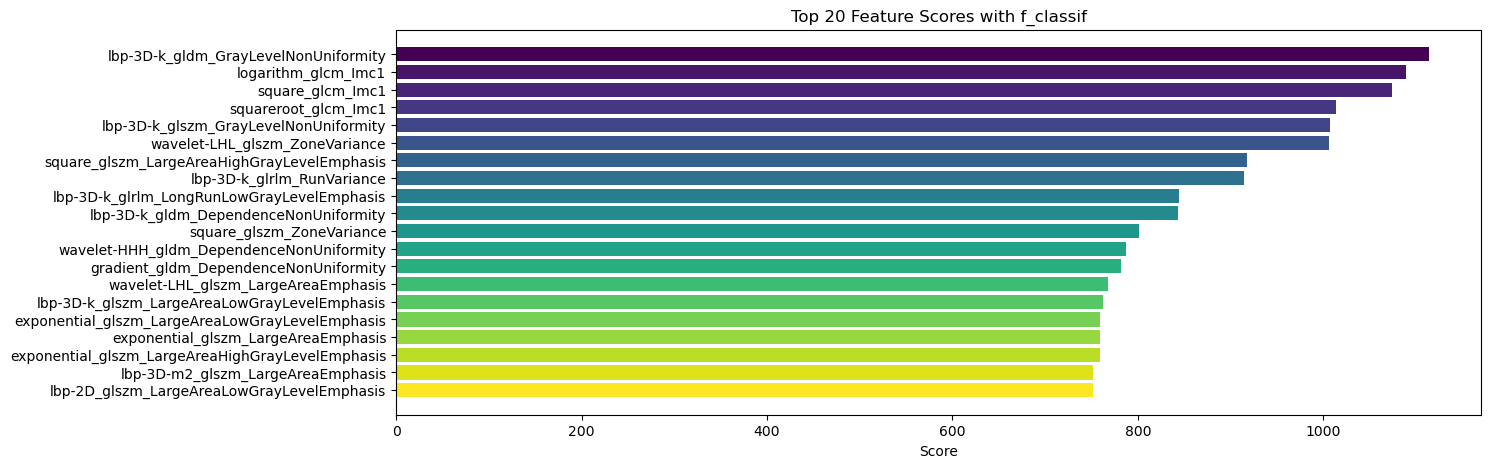

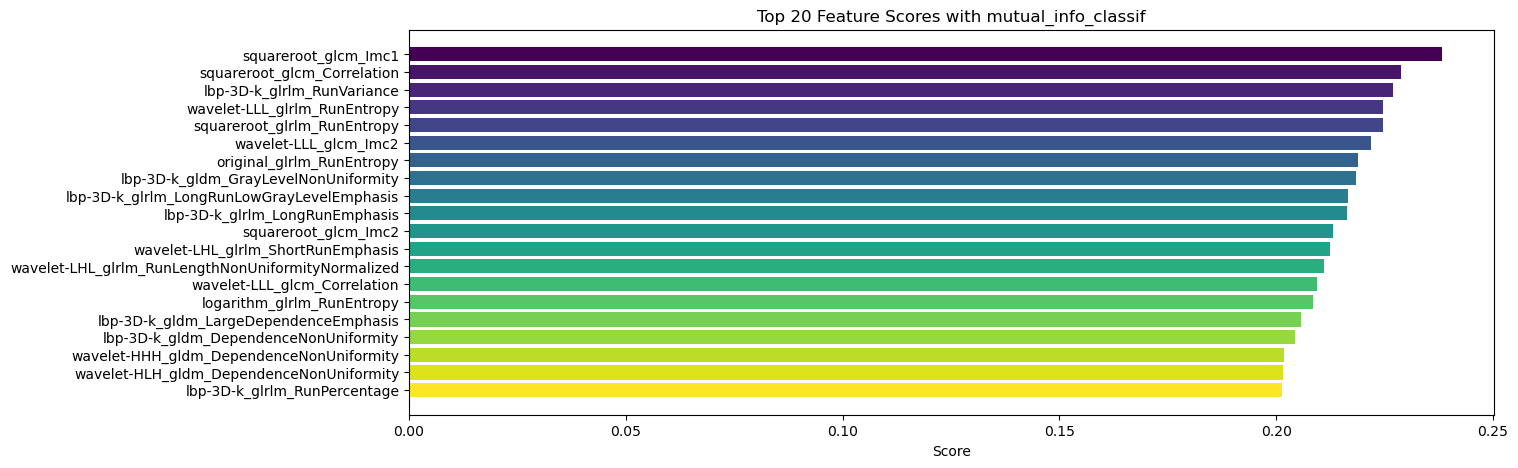

In [45]:
# Plot for top 20 f_classif scores
plt.figure(figsize=(14, 5))
plt.barh(sorted_top_features_f_classif, sorted_top_scores_f_classif, color=cmap(np.linspace(0, 1, 20)))
plt.xlabel('Score')
plt.title('Top 20 Feature Scores with f_classif')
plt.gca().invert_yaxis()  # Inverting y-axis for better readability
plt.show()

# Plot for top 20 mutual_info_classif scores
plt.figure(figsize=(14, 5))
plt.barh(sorted_top_features_mutual_info_classif, sorted_top_scores_mutual_info_classif, color=cmap(np.linspace(0, 1, 20)))
plt.xlabel('Score')
plt.title('Top 20 Feature Scores with mutual_info_classif')
plt.gca().invert_yaxis()  # Inverting y-axis for better readability
plt.show()

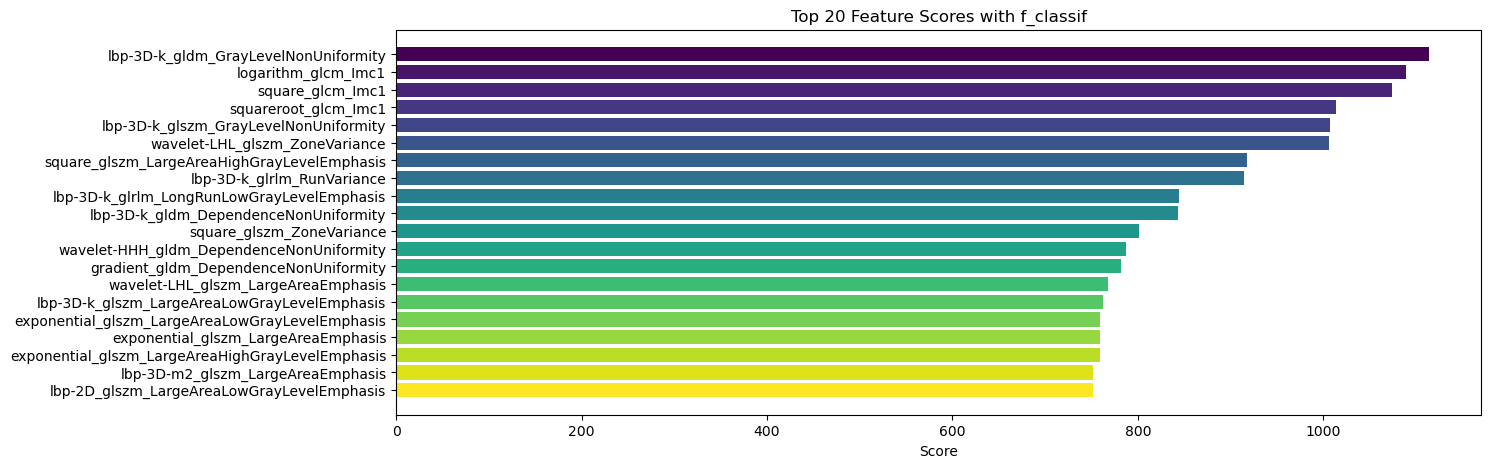

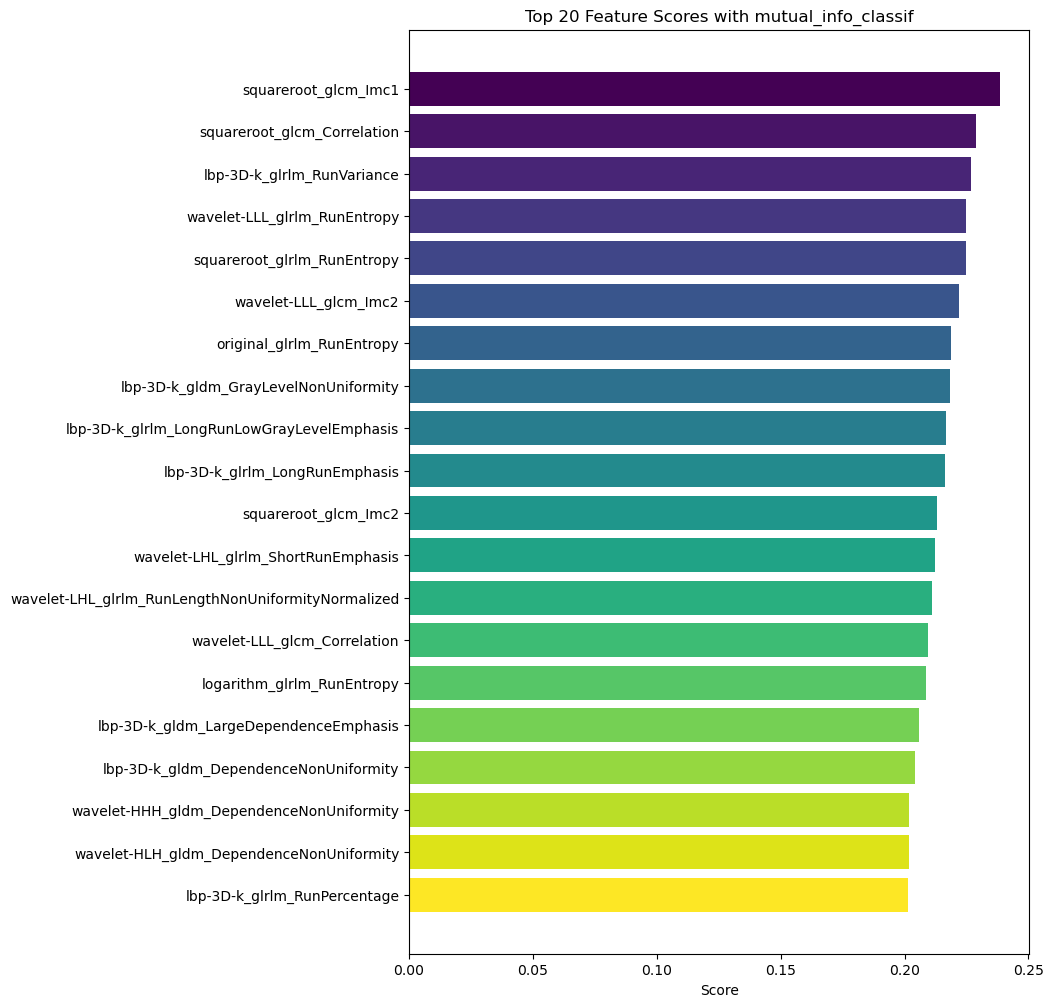

In [36]:
# Identifying top 10 features for f_classif
indices_f_classif = np.argsort(scores_f_classif)[-10:]  # Get indices of top 10 features
top_features_f_classif = X_filtered.columns[indices_f_classif]
top_scores_f_classif = scores_f_classif[indices_f_classif]

# Identifying top 10 features for mutual_info_classif
indices_mutual_info_classif = np.argsort(scores_mutual_info_classif)[-10:]  # Get indices of top 10 features
top_features_mutual_info_classif = X_filtered.columns[indices_mutual_info_classif]
top_scores_mutual_info_classif = scores_mutual_info_classif[indices_mutual_info_classif]

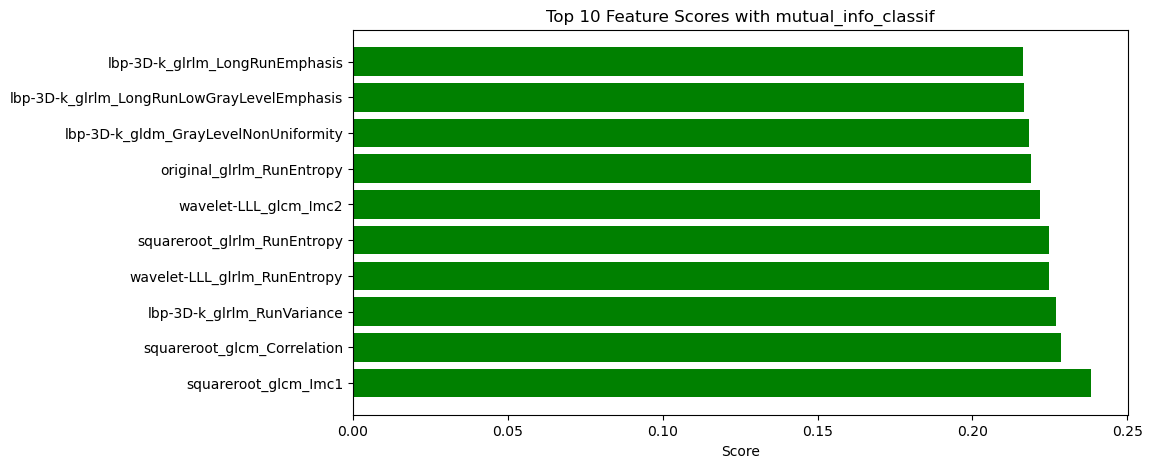

In [38]:
# Plot for top 10 mutual_info_classif scores
plt.figure(figsize=(10, 5))
plt.barh(top_features_mutual_info_classif, top_scores_mutual_info_classif, color='green')
plt.xlabel('Score')
plt.title('Top 10 Feature Scores with mutual_info_classif')
plt.gca().invert_yaxis()  # Inverting y-axis for better readability
plt.show()

In [17]:
# Handling imbalance of the dataset
# Random Forest
# Tree based algorithm can handle imbalance better 

clf = RandomForestClassifier()
clf.fit(X_filtered, y)

feature_importances = pd.Series(clf.feature_importances_, index=X_filtered.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

In [18]:
# Print only non-zero importances
max_length = max(len(feature) for feature in sorted_importances.index)

In [19]:
for feature, importance in sorted_importances.items():
    if importance > 0.01:
        print(f"{feature:<{53}} {importance}")

squareroot_glrlm_RunEntropy                           0.0219932495678884
squareroot_glcm_Imc1                                  0.02121228623125948
squareroot_glcm_Imc2                                  0.020579391539694458
original_glrlm_RunEntropy                             0.01799141139041478
wavelet-LHL_gldm_SmallDependenceEmphasis              0.01453726612748764
lbp-3D-k_gldm_GrayLevelNonUniformity                  0.014275676969338878
wavelet-HHL_gldm_LargeDependenceLowGrayLevelEmphasis  0.014196578011403123
lbp-3D-k_glrlm_LongRunLowGrayLevelEmphasis            0.012369251610654117
lbp-3D-k_glrlm_RunPercentage                          0.0121857965517859
original_shape_Maximum2DDiameterSlice                 0.011456936746652773
gradient_gldm_LargeDependenceEmphasis                 0.010923024026204509


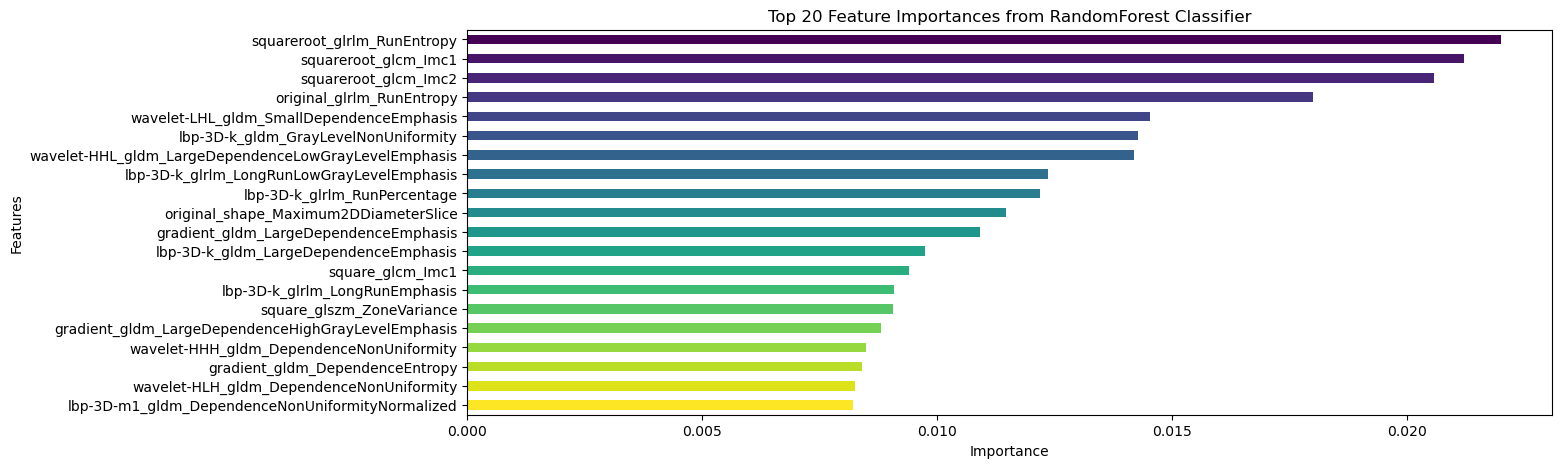

In [47]:
# Create a pandas series with feature importances from the classifier
feature_importances_series = pd.Series(clf.feature_importances_, index=X_filtered.columns)

# Sort the feature importances in descending order
sorted_importances = feature_importances_series.sort_values(ascending=False)

# Using the viridis colormap
cmap = plt.cm.viridis

# Visualize the top 20 features
plt.figure(figsize=(14, 5))
sorted_importances[:20].plot(kind='barh', color=cmap(np.linspace(0, 1, 20)))  # Horizontal bar chart for the top 20 features
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.title('Top 20 Feature Importances from RandomForest Classifier')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

In [ ]:
#other method that might be usful: Recursive Feature Elimination (RFE),L1 Regularization (Lasso Regression),Model-Based Feature Importance(e.g. Random Forests and Gradient Boosting)